In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

('2017-08-23',)


C:\Users\dsrivastava\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: 'date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


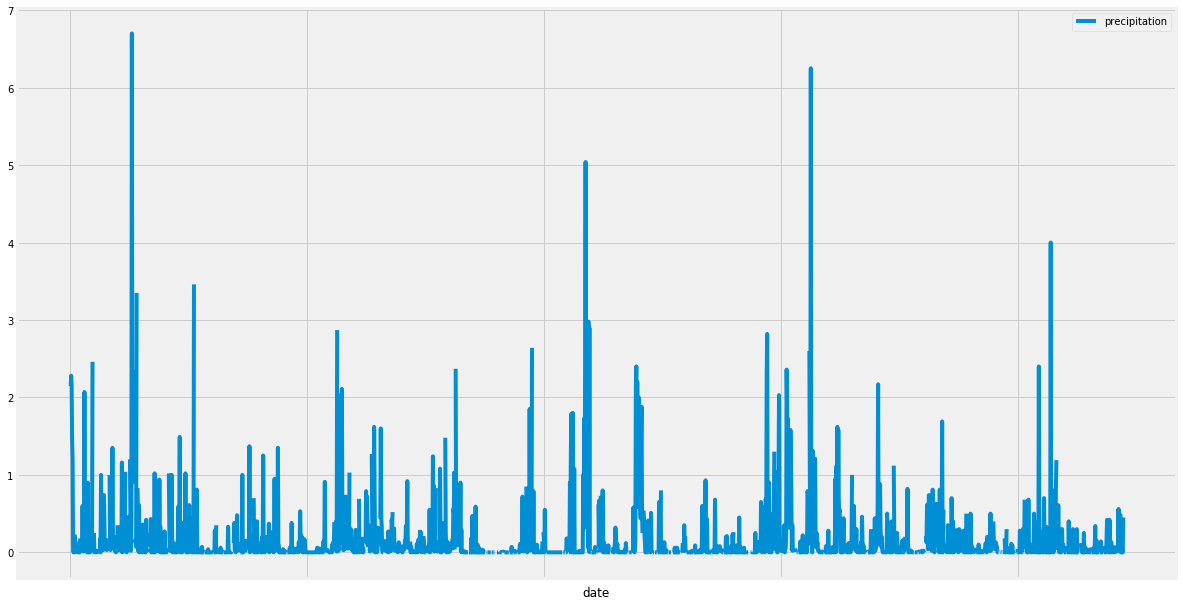

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
atest_db_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(atest_db_date)
# Calculate the date 1 year ago from the last data point in the database
previous_year = dt.date(2017,8,23) - dt.timedelta(days = 365)
#previous_year
# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > previous_year).all()
#results

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(results, columns = ["date", "precipitation"])
prcp_df.set_index(prcp_df["date"], inplace = True)


# Sort the dataframe by date
prcp_df = prcp_df.sort_values("date")
# prcp_df

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(x_compat = True, rot = 90)
precipitation_figure = plt.gcf()
precipitation_figure.set_size_inches(18.5, 10.5)
precipitation_figure.savefig('precipitation.png', dpi=100)


![precipitation](Images/precipitation.png)

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [12]:
# Design a query to show how many stations are available in this dataset?
number_of_stations = len(session.query(Measurement.station).distinct().all())
print(number_of_stations)


9


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

count_number = session.query(Measurement.station, \
                             func.count(Measurement.station)).\
                               group_by(Measurement.station).\
                               order_by(func.count(Measurement.station).desc()).all()

print(count_number)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active = count_number[0]
print (most_active)

most_active

temp_stats = session.query(func.min(Measurement.tobs),\
                          func.max(Measurement.tobs),\
                          func.avg(Measurement.tobs)).\
                            filter(Measurement.station == most_active[0]).\
group_by(Measurement.station).all()
temp_stats
    


('USC00519281', 2772)


[(54.0, 85.0, 71.66378066378067)]

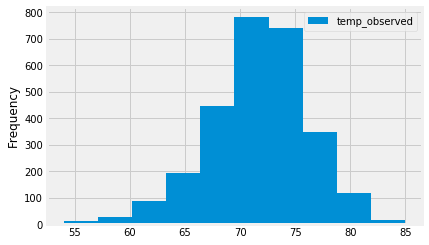

<Figure size 576x432 with 0 Axes>

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_stats = session.query(Measurement.tobs).filter(Measurement.station == most_active[0]).all()
temp_stats_df = pd.DataFrame(temp_stats, columns=["temp_observed"]) 
temp_stats_df.plot(kind = 'hist')
plt.show()
temp_figure = plt.gcf()
temp_figure.set_size_inches(8, 6)
temp_figure.savefig('tempdistribution.png', dpi=100)



![precipitation](Images/station-histogram.png)

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(atest_db_date)
replace_list = "(',)"
for char in replace_list:
   atest_db_date = str(atest_db_date).replace(char, '')
atest_db_date = dt.datetime.strptime(atest_db_date, '%Y-%m-%d')
latest_avg_temp_data = calc_temps(previous_year, atest_db_date)


('2017-08-23',)


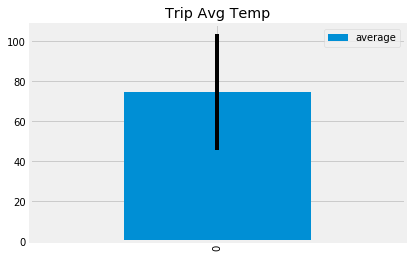

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

atest_avg_temp_df = pd.DataFrame(latest_avg_temp_data, columns = ['minimum', 'average', 'maximum'])

atest_avg_temp_df.plot(kind = 'bar', \
                       y = 'average', \
                       yerr = atest_avg_temp_df['maximum'] - atest_avg_temp_df['minimum'], \
                       title = 'Trip Avg Temp')

In [19]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

def precipitation(start_date, end_date):
    
    sel = [Measurement.station, Measurement.prcp,Measurement.date,  
           Station.name, 
           Station.latitude, 
           Station.longitude, 
           Station.elevation
           ]
    
    return session.query(*sel).\
            filter(Measurement.station == Station.station).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()

for rec in precipitation(previous_year, atest_db_date): 
    print(rec)

('USC00519281', 1.79, '2016-08-23', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
('USC00516128', 0.7, '2016-08-23', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)
('USC00513117', 0.15, '2016-08-23', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
('USC00514830', 0.05, '2016-08-23', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
('USC00519523', 0.02, '2016-08-23', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
('USC00519397', 0.0, '2016-08-23', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
('USC00517948', None, '2016-08-23', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [23]:
# Plot the daily normals as an area plot with `stacked=False`
